In [ ]:
"""
PERTURBATIONSANALYSE ZUR EVALUIERUNG VON XAI-METHODEN MITTELS DER AOPC-METRIK

Dieses Skript dient der quantitativen Evaluation und dem Vergleich verschiedener XAI-Methoden
durch eine Perturbationsanalyse mithilfe der INNVestigate Bibliothek.
Ziel ist die Berechnung der AOPC (Area Over the Perturbation Curve).

Der Prozess umfasst folgende Schritte:
1. Laden eines vortrainierten VGG16-Modells und des zugehörigen Datensatzes (z.B. Oxford-IIIT Pet).
2. Initialisierung ausgewählter XAI-Methoden (z.B. Gradient, LRP, Integrated Gradients) unter
   Verwendung der "innvestigate"-Bibliothek.
3. Systematische Durchführung der Perturbationsanalyse, bei der die Relevanz-Heatmaps der XAI-Methoden
   genutzt werden, um die Reihenfolge der zu störenden Bildregionen festzulegen.
4. Aufzeichnung der Modellgenauigkeit bei jedem Perturbationsschritt.
5. Berechnung und Visualisierung der AOPC-Werte, um die Effektivität der XAI-Methoden objektiv zu
   vergleichen. Eine Methode gilt als effektiver, je schneller die Genauigkeit durch die gezielte
   Störung abfällt.
6. Hilfsfunktionen um das visualiseren der Erklärungen.
"""

In [ ]:
!nvidia-smi

Wed Aug 20 13:20:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:06:10.0 Off |                  Off |
| 30%   29C    P8             13W /  300W |       2MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import imp
import os
import sys

from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
from tensorflow.keras import models
import tensorflow.keras.backend
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam

import tensorflow.compat.v1 as tf1
tf1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

# Hinzufügen des Entwicklungspfades der 'innvestigate'-Bibliothek an den Anfang des sys.path,
# um sicherzustellen, dass die lokale Version importiert wird.example_utils_path = "/mnt/data/environments/innvestigate/examples/"
example_utils_path = os.path.abspath(example_utils_path)

if example_utils_path not in sys.path:
    sys.path.append(example_utils_path)

dev_path = "/mnt/data/environments/innvestigate/src/"

if dev_path not in sys.path:
    sys.path.insert(0, dev_path) # Fügt Ihren Entwicklungspfad an den Anfang der Liste ein

# Importieren der 'innvestigate'-Bibliothek und ihrer Hilfsfunktionen.
import innvestigate
import innvestigate.tools.perturbate
import innvestigate.utils as iutils
# Importieren von Hilfsfunktionen aus den 'innvestigate'-Beispielen.
import utils1 as eutils
import utils1.imagenet as imagenetutils
from innvestigate.tools.perturbate import Perturbation, PerturbationAnalysis

# Konfigurieren des GPU-Speicherwachstums, um zu verhindern, dass alles aufeinmal belegt wird.
physical_gpus = tf.config.list_physical_devices('GPU')
if physical_gpus:
    tf.config.experimental.set_memory_growth(physical_gpus[0], True)
# import checks
print(f"sys.path[0]: {sys.path[0]}")
print(f"Geladenes innvestigate Paket: {innvestigate.__file__}")
print(f"Geladene perturbate.py: {innvestigate.tools.perturbate.__file__}")


/tmp/ipykernel_13361/431551021.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp
2025-08-20 15:51:55.014728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-20 15:51:55.014776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-20 15:51:55.016029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-20 15:51:55.023309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions i

sys.path[0]: /mnt/data/environments/innvestigate/src/
Geladenes innvestigate Paket: /mnt/data/environments/innvestigate/src/innvestigate/__init__.py
Geladene perturbate.py: /mnt/data/environments/innvestigate/src/innvestigate/tools/perturbate.py


2025-08-20 15:51:56.695426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-20 15:51:56.732845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-20 15:51:56.733415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
# Pfad zum vortrainierten VGG16-Modell, Modelle sind im repo unter /trained_models

#MODEL_PATH = './models/VGG16 MODELS/vgg16_imagenet_a96_va63_l150_vl278.h5'
#MODEL_PATH = './models/VGG16 MODELS/vgg16_cifar10_a87_va85_l378_vl448.h5'
MODEL_PATH = './models/VGG16 MODELS/vgg16_oxfordpets_a69_va60_l1310_vl1920.h5'
#MODEL_PATH = './models/VGG16 MODELS/vgg16_caltech101_a68_va56_l1277_vl2056.h5'
#MODEL_PATH = './models/VGG16 MODELS/vgg16_sun397_a79_va58_l761_vl1768.h5'

# Modell kompilieren
model = tf.compat.v1.keras.models.load_model(MODEL_PATH, compile=False)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])#learning rate should be set to 0.0001 as models are trained that way


2025-08-20 15:52:03.575023: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-20 15:52:03.575354: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-20 15:52:03.575568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
# Load dataset
(ds_test, ds_train), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['test', 'train'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
    data_dir='/mnt/data/datasets'
)

def preprocess_vgg(image, label):
    # Resize to VGG16's expected input size
    image = tf.image.resize(image, [224, 224])
    # Apply VGG16 preprocessing (convert to float32 + mean subtraction)
    image = preprocess_input(image)
    return image, label

def one_hot_encode_labels(image, label):
    # Apply one-hot encoding to the label
    label = tf.one_hot(label, 37)
    return image, label

BATCH_SIZE = 256
ds_train = ds_train.take(1000)
ds_test = ds_test.take(800)


# Funktion zur Vorverarbeitung der Bilder für das VGG16-Modell.
ds_train = ds_train.map(preprocess_vgg)
ds_train = ds_train.shuffle(buffer_size=1000)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess_vgg,deterministic=True)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(buffer_size=tf.data.AUTOTUNE)

ds_train = ds_train.map(one_hot_encode_labels)
ds_test = ds_test.map(one_hot_encode_labels)

# Konvertieren des TensorFlow-Datensatzes in NumPy-Arrays
train_images_list = []
train_labels_list = []

for images, labels in tfds.as_numpy(ds_test):
    train_images_list.append(images)
    train_labels_list.append(labels)

train_images = np.concatenate(train_images_list, axis=0)
train_labels = np.concatenate(train_labels_list, axis=0)

# Erstellen eines Testbeispiels für die Perturbationsanalyse.
test_sample = np.copy(train_images[0:1])
print("Test sample shape: {}".format(test_sample.shape))
print("generator variables data type:",(test_sample.dtype))

# Überprüfen der Dimensionen und Datentypen der erstellten Arrays.
print("Train images shape:", train_images.shape)  # Should be (N, 224, 224, 3)
print("Train images dtype:", train_images.dtype)  # Should be float32
print("Train labels shape:", train_labels.shape)  # Should be (N,)
print("Train labels dtype:", train_labels.dtype)  # Should be float32


2025-08-20 15:52:25.595221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-20 15:52:25.595500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-20 15:52:25.595720: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Test sample shape: (1, 224, 224, 3)
generator variables data type: float32
Train images shape: (800, 224, 224, 3)
Train images dtype: float32
Train labels shape: (800, 37)
Train labels dtype: float32


In [ ]:
# Erstellen eines BatchSequence-Generators, der die Daten in Batches für die Analyse bereitstellt.
generator = iutils.sequence.BatchSequence([train_images, train_labels], batch_size=8)

In [ ]:
# Parameter für die Perturbationsanalyse.
perturbation_function = "uniform"
region_shape = (56, 56)
steps = 16
regions_per_step = 1  # Perturbate 1 region per step

# Parameter für die Nachverarbeitung der Bilder zur Visualisierung.
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = "BGRtoRGB"  # keras.applications use BGR format

# VGG16 preprocess_input erwartet Eingaben im [0, 255] Bereich (RGB),
# konvertiert intern zu BGR und subtrahiert Mittelwerte [103.939, 116.779, 123.68] (BGR)
VGG_MEANS_BGR = np.array([103.939, 116.779, 123.68]) # B, G, R

def revert_preprocessing_vgg(X_preprocessed_bgr):
    X_bgr = X_preprocessed_bgr + VGG_MEANS_BGR
    X_rgb = X_bgr[..., ::-1] # Kanalreihenfolge umkehren (BGR zu RGB)
    return X_rgb

def input_postprocessing_vgg(X_vgg_preprocessed):
    X_reverted_to_0_255_rgb = revert_preprocessing_vgg(X_vgg_preprocessed)
    X_reverted_to_0_255_rgb = np.clip(X_reverted_to_0_255_rgb, 0, 255)
    return X_reverted_to_0_255_rgb / 255.0

input_range = (-128, 128)  # format used by keras.applications
noise_scale = (input_range[1] - input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
# fmt: off
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN            TITLE
    # Show input
    ("input",               {},                         input_postprocessing_vgg,   "Input"),
    # Random
    ("random",              {},                         imagenetutils.graymap,     "Random"),
    # Function
    ("gradient",            {"postprocess": "abs"},     imagenetutils.graymap,     "Gradient"),
    ("smoothgrad",
                            {"noise_scale": noise_scale,
                             "postprocess": "square"},  imagenetutils.graymap,     "SmoothGrad"),
    # Signal
    ("deconvnet",           {},                         imagenetutils.bk_proj,     "Deconvnet"),
    ("guided_backprop",     {},                         imagenetutils.bk_proj,     "Guided Backprop"),
    # Interaction
    ("deep_taylor.bounded", {"low": input_range[0],
                             "high": input_range[1]},   imagenetutils.heatmap,     "DeepTaylor"),
    ("input_t_gradient",    {},                         imagenetutils.heatmap,     "Input * Gradient"),
    ("integrated_gradients",{"reference_inputs": ri},   imagenetutils.heatmap,     "Integrated Gradients"),
    ("lrp.z",               {},                         imagenetutils.heatmap,     "LRP-Z"),
    ("lrp.epsilon",         {"epsilon": 1},             imagenetutils.heatmap,     "LRP-Epsilon"),
]
# fmt: on

# Select methods of your choice
selected_methods_indices = [1,2,3,4,5,6,7,8,9,10]
selected_methods = [methods[i] for i in selected_methods_indices]
print(f'Using method(s) "{[method[0] for method in selected_methods]}".')

Using method(s) "['random', 'gradient', 'smoothgrad', 'deconvnet', 'guided_backprop', 'deep_taylor.bounded', 'input_t_gradient', 'integrated_gradients', 'lrp.z', 'lrp.epsilon']".


In [ ]:
# Erstellen eines Modells ohne die finale Softmax-Aktivierungsfunktion,
# da die meisten XAI-Methoden auf den Logits arbeiten.
model_wo_softmax = innvestigate.model_wo_softmax(model)

analyzers = []
for method in selected_methods:
    try:
        analyzer = innvestigate.create_analyzer(
            method[0],          # analysis method identifier
            model_wo_softmax,   # model without softmax output
            **method[1]
        )                     # optional analysis parameters
    except innvestigate.NotAnalyzeableModelException:
        # Not all methods work with all models.
        analyzer = None
    analyzers.append(analyzer)

print("Initial analyzers list created.")

# Korrektur für den 'random'-Analyzer, da dieser in manchen Versionen fehlerhaft ist.
method_names = [m[0] for m in selected_methods]
try:
    random_method_index = method_names.index("random")

    # Create a very simple object that just has an .analyze() method
    correct_random_analyzer = SimpleNamespace(
        analyze=lambda x: np.random.rand(*x.shape)
    )

    # It replaces the broken analyzer in your list with the correct one.
    print("Applying simple fix for 'random' analyzer...")
    analyzers[random_method_index] = correct_random_analyzer

except ValueError:
    # This will run if 'random' is not in your selected_methods list
    print("'random' method not found, no fix applied.")


Initial analyzers list created.
Applying simple fix for 'random' analyzer...


In [ ]:
# Durchführen der Perturbationsanalyse für jede ausgewählte Methode.
scores_selected_methods = dict()
perturbation_analyses = list()

for method, analyzer in zip(selected_methods, analyzers):
    print("Method: {}", method)
    print("Analyser: ", analyzer)

    perturbation = Perturbation(
        perturbation_function, region_shape=region_shape, in_place=False
    )

    perturbation_analysis = PerturbationAnalysis(
        analyzer,
        model,
        generator,
        perturbation,
        recompute_analysis=False,
        steps=steps,
        regions_per_step=regions_per_step,
        verbose=True,
    )
    scores = perturbation_analysis.compute_perturbation_analysis()

    # Speichern der Ergebnisse für die spätere Visualisierung.
    scores_selected_methods[method[0]] = np.array(scores)
    perturbation_analyses.append(perturbation_analysis)
    print()

Method: {} ('random', {}, <function graymap at 0x73d449349940>, 'Random')
Analyser:  namespace(analyze=<function <lambda> at 0x73d3dc0a3d80>)
DEBUG: alles korrekt abgelaufen.


2025-08-20 15:52:40.267720: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel/Assign' id:622 op device:{requested: '', assigned: ''} def:{{{node kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel, kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/mnt/data/environments/thesis/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-08-20 15:52:40.320325: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:544 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_man

Step 1 of 16: 1 regions perturbed. Time elapsed: 13.114 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.344 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.420 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.399 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.452 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.504 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.547 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.570 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.645 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.703 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.727 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.757 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.768 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.811 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.857 seconds.
Step 16 of 16: 16 regions p

2025-08-20 15:53:34.871722: W tensorflow/c/c_api.cc:305] Operation '{name:'block1_conv1/Conv2D/ReadVariableOp' id:22 op device:{requested: '', assigned: ''} def:{{{node block1_conv1/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](block1_conv1/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-08-20 15:53:34.891985: W tensorflow/c/c_api.cc:305] Operation '{name:'block1_conv1/Conv2D/ReadVariableOp' id:22 op device:{requested: '', assigned: ''} def:{{{node block1_conv1/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](block1_conv1/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them o

DEBUG: alles korrekt abgelaufen.
Step 1 of 16: 1 regions perturbed. Time elapsed: 2.290 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.309 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.365 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.369 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.409 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.446 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.507 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.539 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.579 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.634 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.672 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.701 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.704 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.763 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.798 seco

2025-08-20 15:54:21.839411: W tensorflow/c/c_api.cc:305] Operation '{name:'block1_conv1/Conv2D/ReadVariableOp' id:22 op device:{requested: '', assigned: ''} def:{{{node block1_conv1/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](block1_conv1/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-08-20 15:54:21.860777: W tensorflow/c/c_api.cc:305] Operation '{name:'block1_conv1/Conv2D/ReadVariableOp' id:22 op device:{requested: '', assigned: ''} def:{{{node block1_conv1/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](block1_conv1/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them o

DEBUG: alles korrekt abgelaufen.
Step 1 of 16: 1 regions perturbed. Time elapsed: 2.024 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.064 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.109 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.166 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.208 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.231 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.288 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.319 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.354 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.385 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.422 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.467 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.515 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.550 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.588 seco

2025-08-20 15:57:24.863843: W tensorflow/c/c_api.cc:305] Operation '{name:'dense/MatMul/ReadVariableOp' id:629 op device:{requested: '', assigned: ''} def:{{{node dense/MatMul/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](custom_predictions/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-08-20 15:57:24.959843: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_12/Assign' id:1418 op device:{requested: '', assigned: ''} def:{{{node bias_12/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_12, bias_12/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or crea

DEBUG: alles korrekt abgelaufen.
Step 1 of 16: 1 regions perturbed. Time elapsed: 2.241 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.319 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.351 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.409 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.428 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.494 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.509 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.547 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.584 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.619 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.663 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.664 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.728 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.779 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.830 seco

2025-08-20 15:58:13.215618: W tensorflow/c/c_api.cc:305] Operation '{name:'dense/MatMul/ReadVariableOp' id:629 op device:{requested: '', assigned: ''} def:{{{node dense/MatMul/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](custom_predictions/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-08-20 15:58:13.301501: W tensorflow/c/c_api.cc:305] Operation '{name:'gradients_63/MaxNeuronSelection_2/Max_grad/range' id:1704 op device:{requested: '', assigned: ''} def:{{{node gradients_63/MaxNeuronSelection_2/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_2/Max"], _has_manual_control_dependencies=true](gradients_63/MaxNeuronSelection_2/Max_grad/range/start, gradients_63/MaxNeuronSelection_2/Max_grad/Size, gradients_63/MaxNeuronSelection_2/Max_grad/range/d

DEBUG: alles korrekt abgelaufen.
Step 1 of 16: 1 regions perturbed. Time elapsed: 2.318 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.338 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.382 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.434 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.437 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.489 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.535 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.561 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.589 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.625 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.722 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.721 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.763 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.803 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.867 seco

2025-08-20 15:59:02.048952: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_35/Assign' id:2326 op device:{requested: '', assigned: ''} def:{{{node kernel_35/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_35, kernel_35/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-08-20 15:59:02.549977: W tensorflow/c/c_api.cc:305] Operation '{name:'gradients_84/MaxNeuronSelection_3/Max_grad/range' id:2456 op device:{requested: '', assigned: ''} def:{{{node gradients_84/MaxNeuronSelection_3/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_3/Max"], _has_manual_control_dependencies=true](gradients_84/MaxNeuronSelection_3/Max_grad/range/start, gradients_84/MaxNeuronSelection_3/Max_grad/Size, gradients_84/Ma

DEBUG: alles korrekt abgelaufen.
Step 1 of 16: 1 regions perturbed. Time elapsed: 2.284 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.318 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.351 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.399 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.433 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.480 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.528 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.583 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.584 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.659 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.644 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.757 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.757 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.783 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.829 seco

2025-08-20 16:00:02.306302: W tensorflow/c/c_api.cc:305] Operation '{name:'block1_conv1/Conv2D/ReadVariableOp' id:22 op device:{requested: '', assigned: ''} def:{{{node block1_conv1/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](block1_conv1/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-08-20 16:00:02.417503: W tensorflow/c/c_api.cc:305] Operation '{name:'block1_conv1/Conv2D/ReadVariableOp' id:22 op device:{requested: '', assigned: ''} def:{{{node block1_conv1/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](block1_conv1/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them o

DEBUG: alles korrekt abgelaufen.
Step 1 of 16: 1 regions perturbed. Time elapsed: 2.300 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.361 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.378 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.412 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.418 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.483 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.518 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.563 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.631 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.658 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.695 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.736 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.763 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.793 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.809 seco

2025-08-20 16:00:51.126822: W tensorflow/c/c_api.cc:305] Operation '{name:'block1_conv1/Conv2D/ReadVariableOp' id:22 op device:{requested: '', assigned: ''} def:{{{node block1_conv1/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](block1_conv1/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-08-20 16:00:51.233751: W tensorflow/c/c_api.cc:305] Operation '{name:'block1_conv1/Conv2D/ReadVariableOp' id:22 op device:{requested: '', assigned: ''} def:{{{node block1_conv1/Conv2D/ReadVariableOp}} = ReadVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT](block1_conv1/kernel)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them o

DEBUG: alles korrekt abgelaufen.
Step 1 of 16: 1 regions perturbed. Time elapsed: 2.043 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.088 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.128 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.159 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.215 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.257 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.278 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.316 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.356 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.396 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.439 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.477 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.519 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.547 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.591 seco

2025-08-20 16:03:11.508442: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_27/Assign' id:3959 op device:{requested: '', assigned: ''} def:{{{node bias_27/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_27, bias_27/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-08-20 16:03:11.962908: W tensorflow/c/c_api.cc:305] Operation '{name:'gradients_162/MaxNeuronSelection_5/Max_grad/range' id:3969 op device:{requested: '', assigned: ''} def:{{{node gradients_162/MaxNeuronSelection_5/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_5/Max"], _has_manual_control_dependencies=true](gradients_162/MaxNeuronSelection_5/Max_grad/range/start, gradients_162/MaxNeuronSelection_5/Max_grad/Size, gradients_162/MaxNeuronSelection_5/Max

DEBUG: alles korrekt abgelaufen.
Step 1 of 16: 1 regions perturbed. Time elapsed: 2.262 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.313 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.388 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.410 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.464 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.481 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.552 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.652 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.685 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.715 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.684 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.758 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.828 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.859 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.835 seco

2025-08-20 16:04:11.053168: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_41/Assign' id:4627 op device:{requested: '', assigned: ''} def:{{{node bias_41/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_41, bias_41/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-08-20 16:04:11.526348: W tensorflow/c/c_api.cc:305] Operation '{name:'gradients_183/MaxNeuronSelection_6/Max_grad/range' id:4637 op device:{requested: '', assigned: ''} def:{{{node gradients_183/MaxNeuronSelection_6/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_6/Max"], _has_manual_control_dependencies=true](gradients_183/MaxNeuronSelection_6/Max_grad/range/start, gradients_183/MaxNeuronSelection_6/Max_grad/Size, gradients_183/MaxNeuronSelection_6/Max

DEBUG: alles korrekt abgelaufen.
Step 1 of 16: 1 regions perturbed. Time elapsed: 2.291 seconds.
Step 2 of 16: 2 regions perturbed. Time elapsed: 2.351 seconds.
Step 3 of 16: 3 regions perturbed. Time elapsed: 2.377 seconds.
Step 4 of 16: 4 regions perturbed. Time elapsed: 2.387 seconds.
Step 5 of 16: 5 regions perturbed. Time elapsed: 2.471 seconds.
Step 6 of 16: 6 regions perturbed. Time elapsed: 2.470 seconds.
Step 7 of 16: 7 regions perturbed. Time elapsed: 2.580 seconds.
Step 8 of 16: 8 regions perturbed. Time elapsed: 2.577 seconds.
Step 9 of 16: 9 regions perturbed. Time elapsed: 2.609 seconds.
Step 10 of 16: 10 regions perturbed. Time elapsed: 2.672 seconds.
Step 11 of 16: 11 regions perturbed. Time elapsed: 2.675 seconds.
Step 12 of 16: 12 regions perturbed. Time elapsed: 2.739 seconds.
Step 13 of 16: 13 regions perturbed. Time elapsed: 2.771 seconds.
Step 14 of 16: 14 regions perturbed. Time elapsed: 2.818 seconds.
Step 15 of 16: 15 regions perturbed. Time elapsed: 2.824 seco

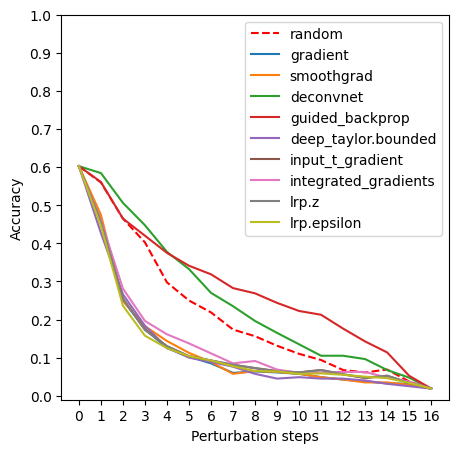

In [ ]:
# Visualisierung der Perturbationskurve und AOPC Werte
fig = plt.figure(figsize=(5, 5))
aopc = list()

for method_name in scores_selected_methods.keys():
    scores = scores_selected_methods[method_name]
    accuracy = scores[:, 1]
    aopc.append(accuracy[0] - np.mean(accuracy))

    label = {method_name}
    print(f"{method_name} AOPC: {aopc[-1]:.3f}")
    value = f"{aopc[-1]:.3f}".replace('.', ',')
    print(f"{value}")
    # strichlinie for 'random' method
    if method_name == "random":
        plt.plot(accuracy,label=label,color="red", linestyle="--")
    else:
        plt.plot(accuracy, label=label)  # Default for others

plt.xlabel("Perturbation steps")
plt.ylabel("Accuracy")
plt.xticks(np.arange(scores.shape[0]))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

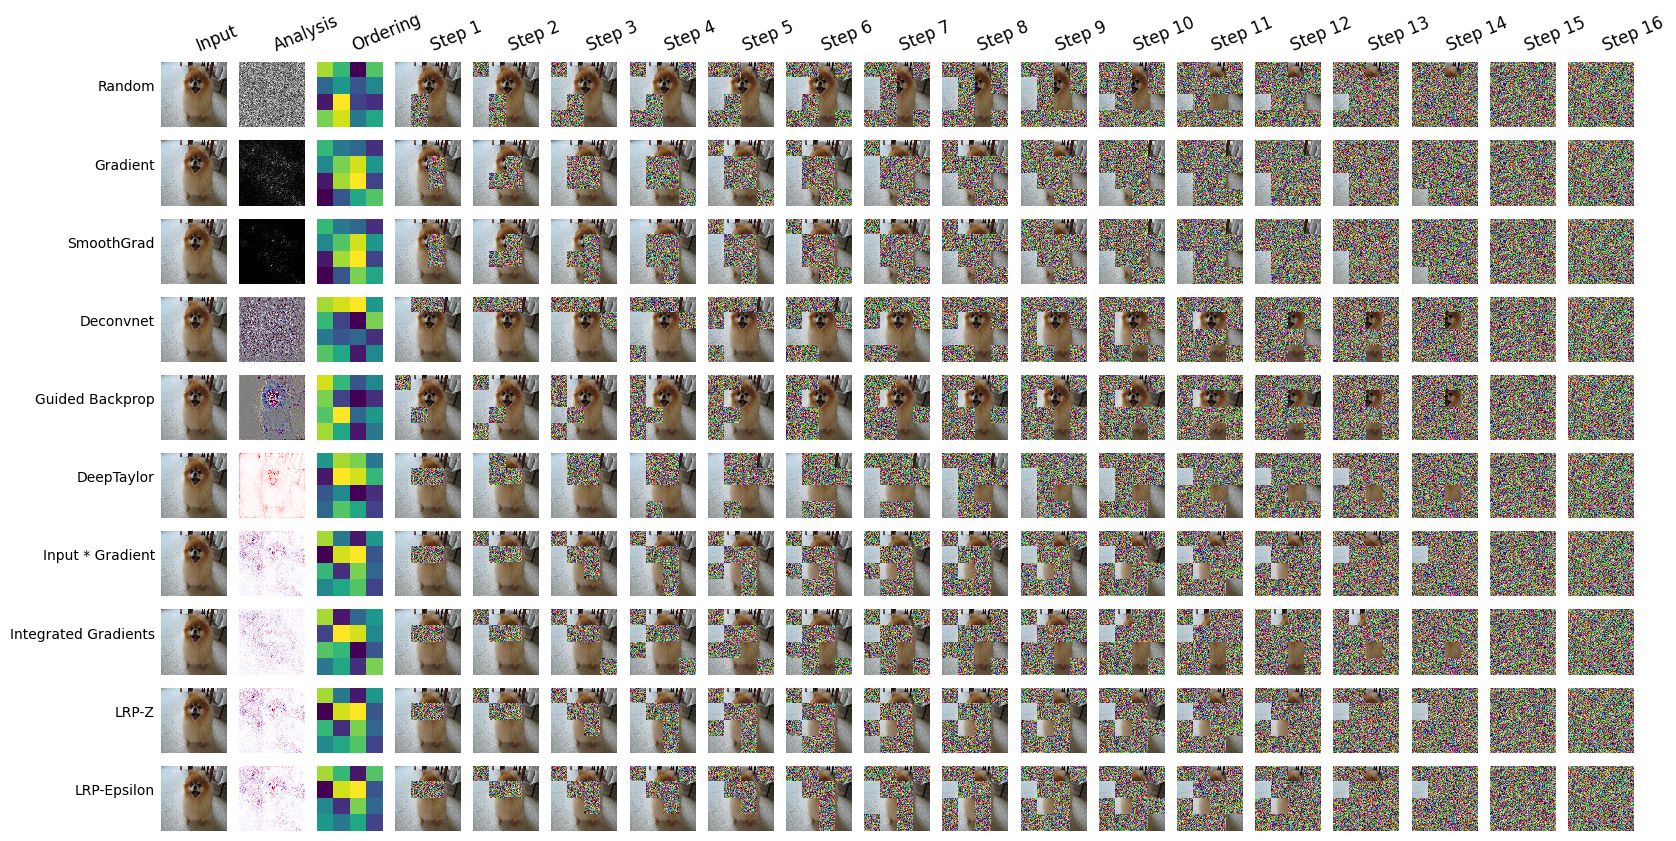

In [ ]:
# Diese funktionen sind Hilfsfunktionen zur visualisierung der einzelnen Perturbationsschritte
# Die Auskommentierten lines sind sehr hilfreich für debugging.
test_sample = np.copy(train_images[367:368])

# Now plot the perturbation step by step.
plt.figure()
grid, row_labels = [], []
col_labels = ["Input", "Analysis", "Ordering"] + [
    "Step {}".format(i + 1) for i in range(steps)
]
heatmaps_for_extra_plot = []

for perturbation_analysis, method in zip(perturbation_analyses, selected_methods):
    #print(f"Current method tuple: {method}")
    #print(f"Type of perturbation_analysis: {type(perturbation_analysis)}")
    row_labels.append([method[-1]])
    samples = list()
    #print(f"Initialized samples list: {samples}")

    # Reset the perturbation_analysis
    perturbation_analysis.perturbation.num_perturbed_regions = 1

    sample = test_sample
    #print(f"test_sample shape: {test_sample.shape}, dtype: {test_sample.dtype}")
    #print(f"sample min: {np.min(sample)}, sample max: {np.max(sample)}")

    analysis = perturbation_analysis.analyzer.analyze(sample)


    #print(f"analysis shape: {analysis.shape}, dtype: {analysis.dtype}")
    #print(f"analysis min: {np.min(analysis)}, analysis max: {np.max(analysis)}")

    # reduce_fucntion macht Divide into regions and order them according to their analysis score, erwarten 1 s/w kanal nicht 3  deshalb muss reduzieren dafür.

    if analysis.shape[-1] == 3: # Wenn(1, 224, 224, 1) in der Analyse macht zu (1, 224, 224, 1) für ordering
        analysis_for_ranking = np.mean(analysis, axis=-1, keepdims=True)
    else: # Annahme: (1, 224, 224, 1)
        analysis_for_ranking = analysis

    aggregated_regions = perturbation_analysis.perturbation.reduce_function(
        np.moveaxis(analysis_for_ranking, 3, 1), axis=1, keepdims=True
    )
    #print(f"moved_analysis shape: {aggregated_regions.shape}")
    #print(f"aggregated_regions (after reduce_function) shape: {aggregated_regions.shape}, dtype: {aggregated_regions.dtype}")

    aggregated_regions = perturbation_analysis.perturbation._aggregate_regions(
        aggregated_regions
    )

    #input ist 244x244, divide in 61x61 region, d.h. 224/61 x 224/61 = 4x4 = 16 regionen
    #print(f"region_shape: {perturbation_analysis.perturbation.region_shape}")
    #print(f"aggregated_regions (after _aggregate_regions) shape: {aggregated_regions.shape}, dtype: {aggregated_regions.dtype}")

    ranks = perturbation_analysis.perturbation._compute_region_ordering(
        aggregated_regions
    )
    #print(f"ranks shape: {ranks.shape}, dtype: {ranks.dtype}")
    #print(f"ranks content example (first batch, first channel): {ranks[0][0]}")

    # Perturbate for some steps
    for i in range(steps + 1):
        # Plot the original image and analysis without any perturbation
        if i > 0:
            perturbation_analysis.perturbation.num_perturbed_regions += (
                perturbation_analysis.regions_per_step
            )
            # Perturbate
            sample = perturbation_analysis.compute_on_batch(sample, analysis)
            #print(f"Perturbed sample shape: {sample.shape}, dtype: {sample.dtype}")
            #print(f"Perturbed sample min: {np.min(sample)}, Perturbed sample max: {np.max(sample)}")

        sample_rgb_0_1 = input_postprocessing_vgg(np.copy(sample)) # Erzeugt RGB [0,1] weil imagenetutils.postprocess macht aus 0,1 wieder 255 rgb bild
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        sample_to_show = imagenetutils.postprocess(sample_rgb_0_1, color_conversion=None, channels_first=channels_first)
        #print(f"sample_to_show (after imagenet.postprocess) shape: {sample_to_show.shape}")
        sample_to_show = np.clip(sample_to_show, 0, 1)
        #print(f"sample_to_show (after clip) min: {np.min(sample_to_show)}, max: {np.max(sample_to_show)}")

        samples.append(sample_to_show[0])
        #print(f"Appended sample shape: {sample_to_show[0].shape}")
        #print(f"samples list length: {len(samples)}")

        heatmaps_for_extra_plot.append({'title': method[-1], 'heatmap': samples})

    # Plot analysis
    analysis = method[2](analysis)

    # Add analysis and ranking
    samples.insert(1, analysis[0])
    samples.insert(2, -ranks[0][0])

    grid.append(samples)

eutils.plot_image_grid(grid, row_labels, list(), col_labels)
plt.show()

--- Label-Informationen für das Testbild (Index: 706) ---
Shape des Testbildes: (1, 224, 224, 3)
Wahres Label (Klasse): 33
Vorhergesagtes Label (Klasse): 33
Vorhergesagtes Label (Klasse): 33 (Name: Sphynx)


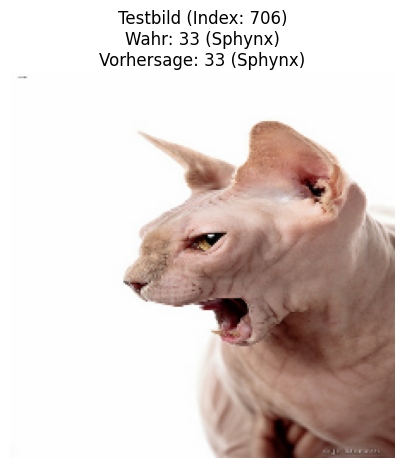

In [ ]:
#Weitere Hilfsfunktionen zur visualisierung einzelner Erklärungen anhand des indexes aus dem Datensatz

image_index_for_label_check = 706

test_sample_image = np.copy(train_images[image_index_for_label_check:image_index_for_label_check+1])
test_sample_true_label_one_hot = np.copy(train_labels[image_index_for_label_check:image_index_for_label_check+1])

# Ermitteln des wahren Labels als einzelne Klassennummer
true_label_class = np.argmax(test_sample_true_label_one_hot, axis=1)[0]
raw_predictions = model.predict(test_sample_image)
predicted_label_class = np.argmax(raw_predictions, axis=1)[0]

#label name in ds_info fischen
if 'ds_info' in globals() and ds_info is not None:
    try:
        class_names = ds_info.features['label'].names
        if 0 <= true_label_class < len(class_names):
            true_label_name = class_names[true_label_class]
        else:
            true_label_name = f"Index {true_label_class} ungültig"

        if 0 <= predicted_label_class < len(class_names):
            predicted_label_name = class_names[predicted_label_class]
        else:
            predicted_label_name = f"Index {predicted_label_class} ungültig"

    except Exception as e:
        print(f"Fehler beim Abrufen der Klassennamen: {e}")
        true_label_name = "Fehler"
        predicted_label_name = "Fehler"
else:
    print("Hinweis: ds_info ist nicht verfügbar, um Klassennamen abzurufen.")


print(f"--- Label-Informationen für das Testbild (Index: {image_index_for_label_check}) ---")
print(f"Shape des Testbildes: {test_sample_image.shape}")
print(f"Wahres Label (Klasse): {true_label_class}")
print(f"Vorhergesagtes Label (Klasse): {predicted_label_class}")
print(f"Vorhergesagtes Label (Klasse): {predicted_label_class} (Name: {predicted_label_name})")


display_image = input_postprocessing_vgg(np.copy(test_sample_image))
display_image_clipped = np.clip(display_image, 0, 1)

plt.figure(figsize=(5, 5))
plt.imshow(display_image_clipped[0]) # [0] um die Batch-Dimension zu entfernen
title_str = (f"Testbild (Index: {image_index_for_label_check})\n"
              f"Wahr: {true_label_class} ({true_label_name})\n"
              f"Vorhersage: {predicted_label_class} ({predicted_label_name})")
plt.title(title_str)
plt.axis('off')
plt.show()

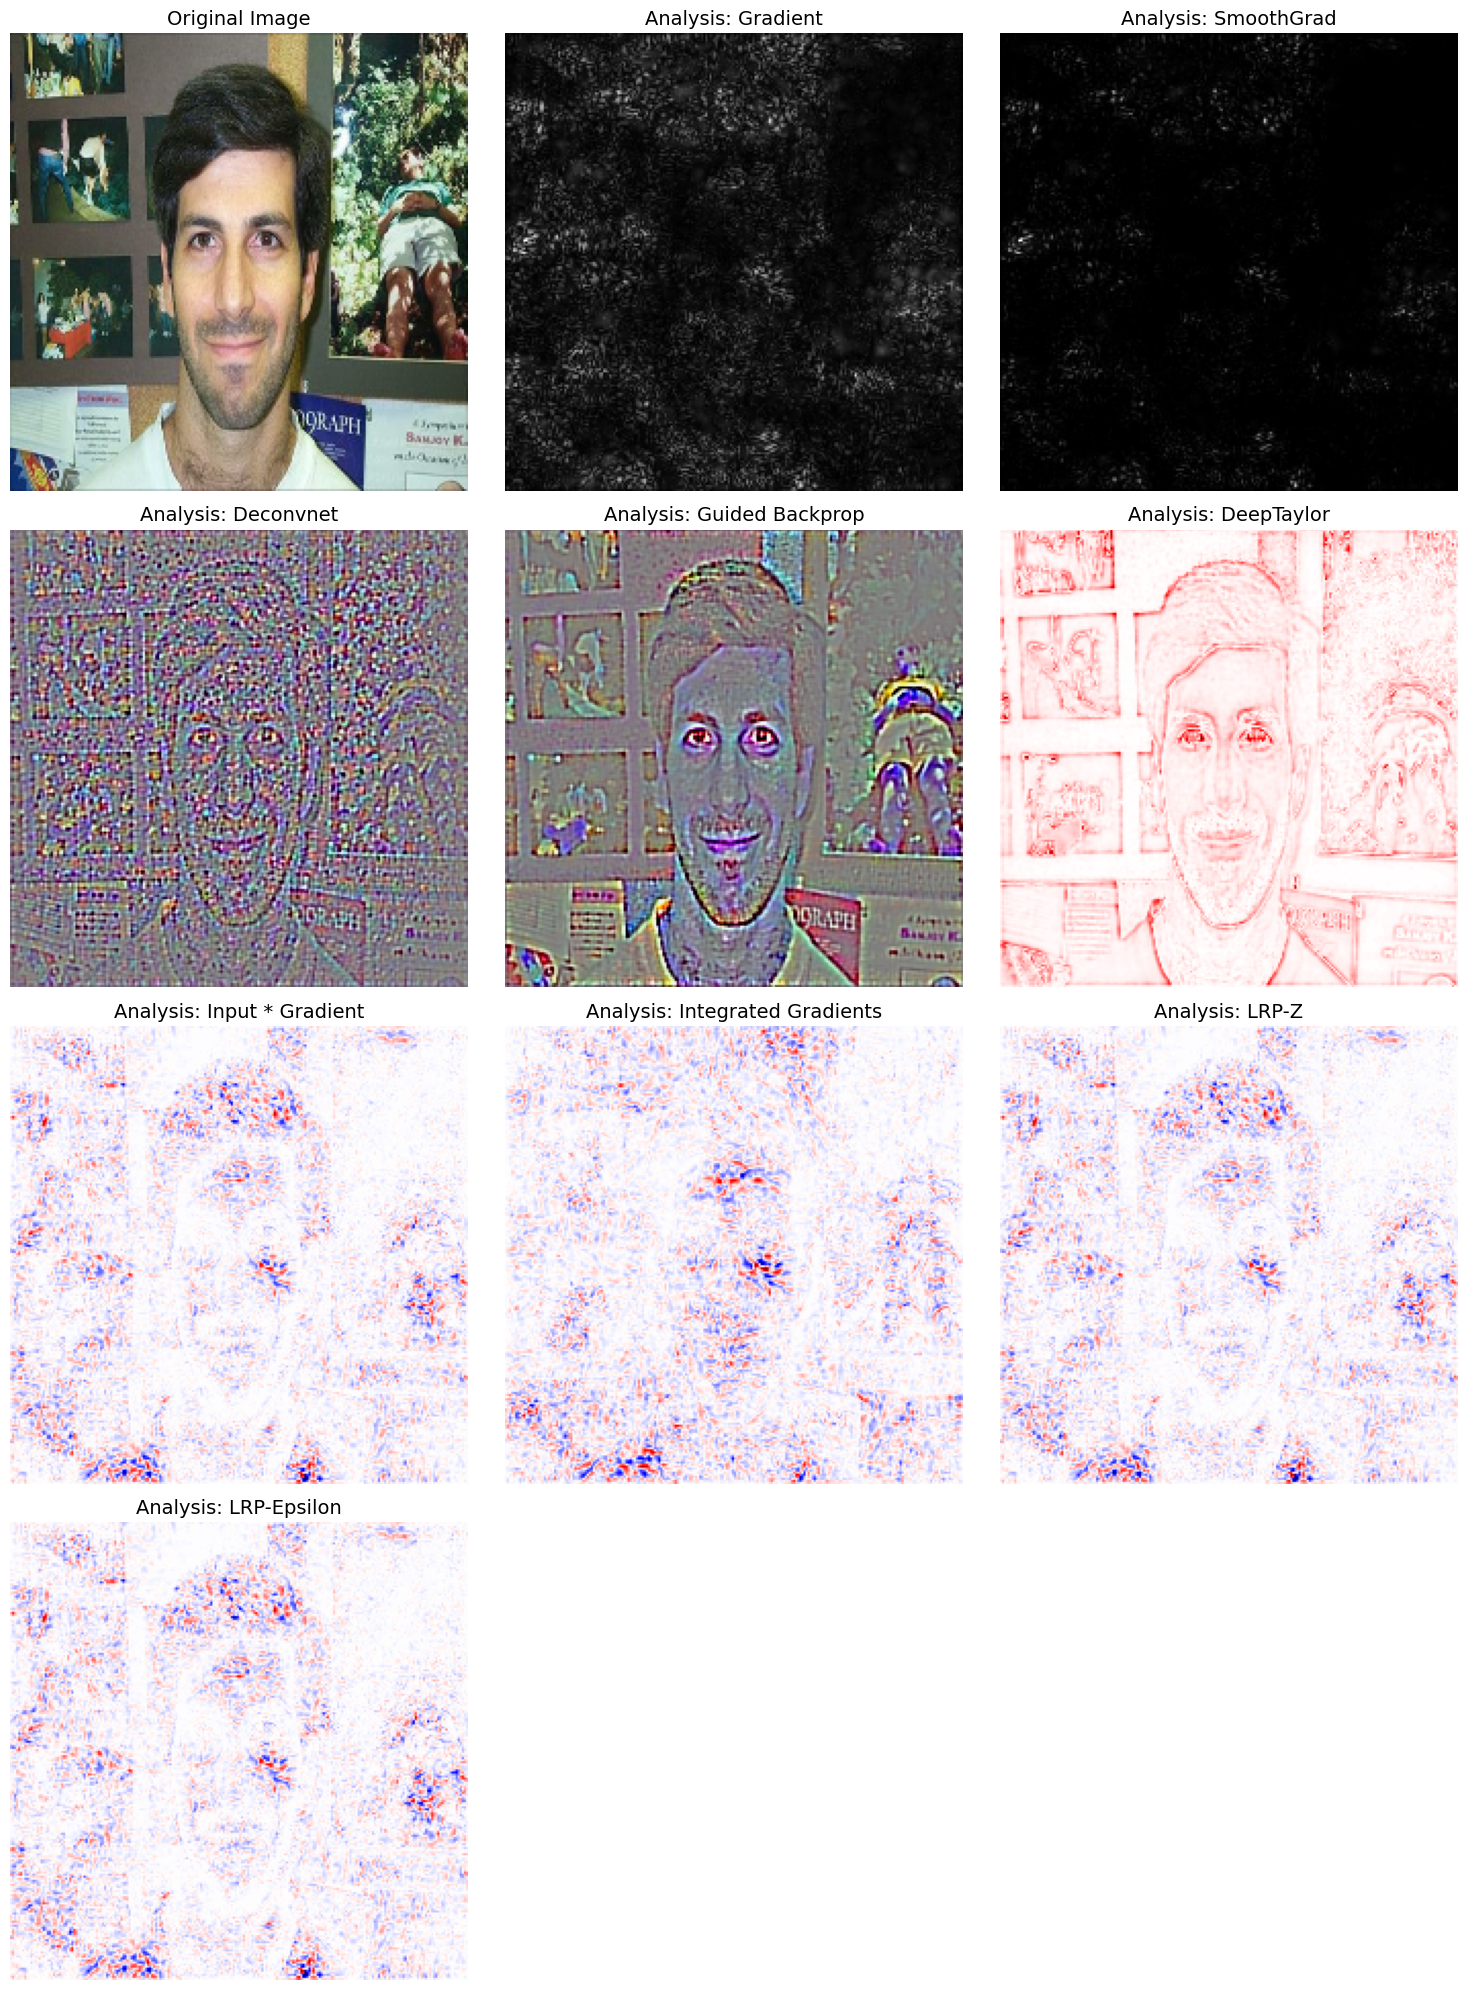

In [ ]:
# Weitere Hilfsfunktion zur Visualiserung der Erklärungen.
# Dise Funktion plotet für ein spezifischen index alle XAI-Methoden nebeneinander.

import math
test_sample = np.copy(train_images[705:706])
num_methods = len(selected_methods)
num_total_plots = 1 + num_methods

# Layout bestimmen (z.B. 2 Spalten, Reihen nach Bedarf)
ncols = 3
nrows = math.ceil(num_total_plots / ncols)

# Angestrebte Größe für jeden Subplot (z.B. 5x5 Zoll für eine gute Darstellung von 224x224)
subplot_size = 5
fig_width = ncols * subplot_size
fig_height = nrows * subplot_size

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
axes_flat = axes.flatten() # Macht aus dem 2D-Array von Achsen ein 1D-Array für einfache Iteration

# 1. Original test_sample plotten
ax_orig = axes_flat[0]
original_sample_display = input_postprocessing_vgg(np.copy(test_sample))
original_sample_display_clipped = np.clip(original_sample_display, 0, 1)

ax_orig.imshow(original_sample_display_clipped[0]) # [0] um die Batch-Dimension zu entfernen
ax_orig.set_title("Original Image", fontsize=14)
ax_orig.axis('off')

for i, (current_perturbation_analysis, method_tuple) in enumerate(zip(perturbation_analyses, selected_methods)):
    ax_idx = i + 1 # Startet bei axes_flat[1]
    if ax_idx >= len(axes_flat): # Falls mehr Methoden als Subplots im Raster sind (sollte nicht passieren bei guter Layout-Planung)
        print(f"Warnung: Nicht genug Subplots für Methode {method_tuple[-1]}")
        break

    ax_current = axes_flat[ax_idx]
    method_name_label = method_tuple[-1]
    postproc_function = method_tuple[2]

    # Hole die rohe Analyse
    raw_analysis = current_perturbation_analysis.analyzer.analyze(np.copy(test_sample))

    # Wende die methodenspezifische Postprocessing-Funktion für die Visualisierung an
    analysis_heatmap_visual = postproc_function(raw_analysis)

    if analysis_heatmap_visual.ndim == 4 and analysis_heatmap_visual.shape[0] == 1:
        display_heatmap_data = analysis_heatmap_visual[0]
    else:
        display_heatmap_data = analysis_heatmap_visual

    display_heatmap_data_clipped = np.clip(display_heatmap_data, 0, 1)

    if display_heatmap_data_clipped.ndim == 2 or (display_heatmap_data_clipped.ndim == 3 and display_heatmap_data_clipped.shape[-1] == 1):
        cmap_choice = 'gray' if postproc_function.__name__ == 'graymap' else 'viridis'
        ax_current.imshow(display_heatmap_data_clipped.squeeze(), cmap=cmap_choice)
    elif display_heatmap_data_clipped.ndim == 3 and display_heatmap_data_clipped.shape[-1] == 3: # RGB
        ax_current.imshow(display_heatmap_data_clipped)
    else:
        ax_current.text(0.5, 0.5, 'Error: Invalid Shape', ha='center', va='center')
        print(f"  WARNUNG: Unerwartete Form der Heatmap-Daten für {method_name_label}: {display_heatmap_data_clipped.shape}.")

    ax_current.set_title(f"Analysis: {method_name_label}", fontsize=14)
    ax_current.axis('off')

# Nicht verwendete Subplots ausschalten (falls num_total_plots < nrows * ncols)
for j in range(num_total_plots, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout() # Passt Subplots an, um Überlappungen zu vermeiden
plt.show()